In [38]:
import pandas as pd
from tqdm import tqdm
import geopy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time
import requests as rq


plt.style.use('ggplot')

In [2]:
file_path = "D:\\hippo\\Documents\\PYTHON\\DATA\\gouv\\"
file_name = "dvf-communes-2019.csv"
df = pd.read_csv(file_path+file_name,sep=";")

In [3]:
df.head()

,ID,INSEE_COM,INSEE_DEP,INSEE_REG,CODE_EPCI,NOM_COM_M,POPULATION,Nb_Ventes,PrixMoyen_M2
0,COMMUNE_0000000009760754,32216,32,76,200072320.0,LOURTIES MONBRUN,152,NaN,NaN
1,COMMUNE_0000000009756744,47033,47,75,200036523.0,BOUDY DE BEAUREGARD,412,4.0,1421.0
2,COMMUNE_0000000009760252,32009,32,76,243200425.0,ARMOUS ET CAU,86,NaN,NaN
3,COMMUNE_0000000009754403,38225,38,84,243801024.0,AUTRANS MEAUDRE EN VERCORS,2969,47.0,2667.0
4,COMMUNE_0000000009727903,62890,62,32,200044030.0,WILLEMAN,182,3.0,967.0


In [4]:
df.shape

(34886, 9)

There are 34886 entries in the dataframe corresponding to the number of metropolitan municipalities.
Some of them have no data.

In [5]:
df.describe()

,INSEE_REG,CODE_EPCI,POPULATION,Nb_Ventes,PrixMoyen_M2
count,34886.000000,3.483700e+04,3.488600e+04,26822.000000,26822.000000
mean,52.462420,2.127412e+08,1.950264e+03,24.576243,1635.830177
std,24.216652,2.013492e+07,1.540069e+04,128.963903,864.263847
min,11.000000,2.000002e+08,0.000000e+00,1.000000,350.000000
25%,28.000000,2.000659e+08,1.990000e+02,2.000000,1101.000000
50%,44.000000,2.000696e+08,4.540000e+02,5.000000,1449.500000
75%,76.000000,2.412007e+08,1.147000e+03,13.000000,1933.000000
max,94.000000,2.495005e+08,2.190327e+06,7411.000000,14803.000000


There were 26822 sell in 2019. For a mean price of 1627€/m².

Renaming the columns to simplify access and understanding

In [6]:
df.columns=['ID','CP','DEPT','REGION','EPCI','NOM','POPULATION','VENTES','PRIX']

In [7]:
df.head()

,ID,CP,DEPT,REGION,EPCI,NOM,POPULATION,VENTES,PRIX
0,COMMUNE_0000000009760754,32216,32,76,200072320.0,LOURTIES MONBRUN,152,NaN,NaN
1,COMMUNE_0000000009756744,47033,47,75,200036523.0,BOUDY DE BEAUREGARD,412,4.0,1421.0
2,COMMUNE_0000000009760252,32009,32,76,243200425.0,ARMOUS ET CAU,86,NaN,NaN
3,COMMUNE_0000000009754403,38225,38,84,243801024.0,AUTRANS MEAUDRE EN VERCORS,2969,47.0,2667.0
4,COMMUNE_0000000009727903,62890,62,32,200044030.0,WILLEMAN,182,3.0,967.0


Updating our dataframe to exclude NaN values and creating a backup df with all data

In [8]:
df_all_data = df
with_na = df.shape[0]
df = df.dropna()
without_na = df.shape[0]
print(f"{with_na-without_na} rows deleted!")

8112 rows deleted!


We now want to see in which cities did the most sales took place and where were the biggest deals.

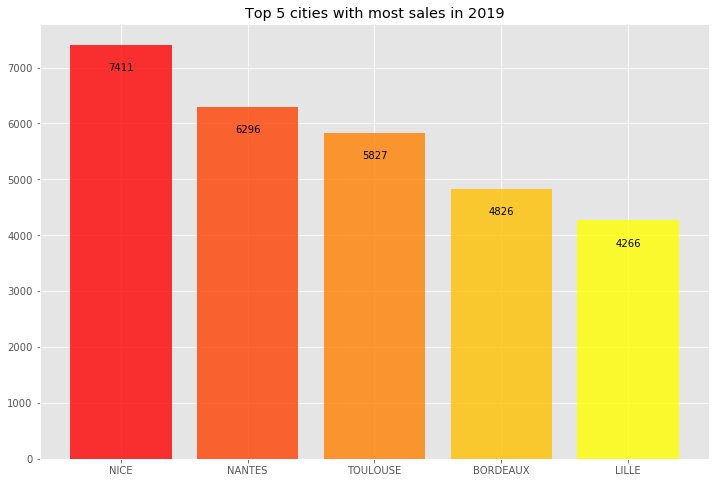

In [9]:
max_sales = df[['NOM','VENTES']].sort_values('VENTES',ascending=False)[:5]

fig,ax = plt.subplots(figsize=(12,8))
colors = cm.autumn(np.linspace(0,1,len(max_sales['NOM'])))
bar = ax.bar(max_sales['NOM'],max_sales['VENTES'],color=colors,alpha=.8)

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2.0, height-500, int(height),c='k', ha='center', va='bottom')

plt.title("Top 5 cities with most sales in 2019")
plt.savefig("images/Top5Sales.png")
plt.show()

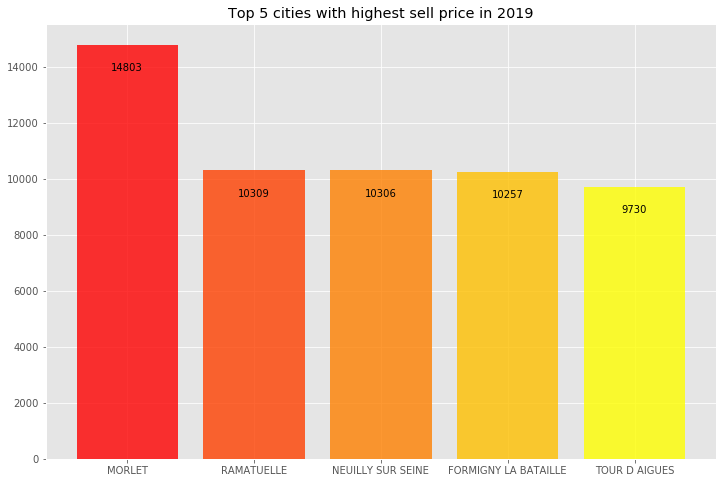

In [10]:
max_price = df[['NOM','PRIX']].sort_values('PRIX',ascending=False)[:5]

fig,ax = plt.subplots(figsize=(12,8))
colors = cm.autumn(np.linspace(0,1,len(max_price['NOM'])))
bar = ax.bar(max_price['NOM'],max_price['PRIX'],color=colors,alpha=.8)

for rect in bar:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2.0, height-1000, int(height),c='k', ha='center', va='bottom')

plt.title("Top 5 cities with highest sell price in 2019")
plt.savefig("images/Top5Prices.png")
plt.show()

In [11]:
list_correct_dept = list(map(lambda x: "0"+x if len(x)==1 else x, df['DEPT']))
df.loc[:,"DEPT"] = list_correct_dept

c:\users\hippo\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Create a dictionnary with names matching dept number from goverment api.

In [12]:

BASE_URL = "https://geo.api.gouv.fr/departements/"
dict_dept = {}
list_dept = list(df['DEPT'].unique())
for dept in tqdm(list_dept):
    info_dept = rq.get(BASE_URL+dept).json()
    name_dept = info_dept['nom']
    dict_dept[dept] = name_dept


100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:30<00:00,  2.99it/s]


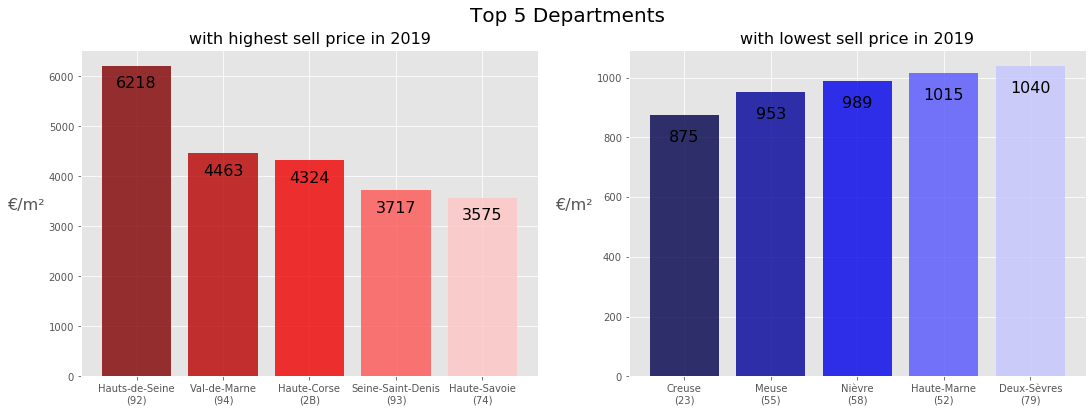

In [13]:
cols = ['DEPT','POPULATION','VENTES','PRIX']
df_dept_prix = df.groupby('DEPT')['PRIX'].mean()#sort_values('DEPT')
df_dept_ventes = df.groupby('DEPT')['VENTES'].sum()#sort_values('DEPT')
df_dept = pd.concat([df_dept_prix,df_dept_ventes], axis=1)
df_dept = df_dept.sort_values('PRIX')
labels1 = list(map(lambda x: f"{dict_dept[x]}\n({x})",df_dept[:5].index))


fig,axs = plt.subplots(1,2, figsize=(18,6))

font_param = {'fontsize':16}

# Highest prices
colors1 = cm.seismic(np.linspace(1,0,10))
df_dept = df_dept.sort_values('PRIX',ascending=False)
labels1 = list(map(lambda x: f"{dict_dept[x]}\n({x})",df_dept[:5].index))
bar1 = axs[0].bar(labels1, df_dept['PRIX'][:5],color = colors1,alpha=.8)

for rect in bar1:
    height = rect.get_height()
    axs[0].text(rect.get_x() + rect.get_width()/2.0, height-500, int(height),c='k', ha='center', va='bottom', fontdict=font_param)
    
axs[0].set_title("with highest sell price in 2019", fontdict=font_param)
axs[0].set_ylabel("€/m²", rotation=0, ha='right', fontdict=font_param)

# Lowest prices

colors2 = cm.seismic(np.linspace(0,1,10))
df_dept = df_dept.sort_values('PRIX')
labels2 = list(map(lambda x: f"{dict_dept[x]}\n({x})",df_dept[:5].index))
bar2 = axs[1].bar(labels2, df_dept['PRIX'][:5],color = colors2,alpha=.8)

for rect in bar2:
    height = rect.get_height()
    axs[1].text(rect.get_x() + rect.get_width()/2.0, height-100, int(height),c='k', ha='center', va='bottom', fontdict=font_param)

axs[1].set_title("with lowest sell price in 2019", fontdict=font_param)
axs[1].set_ylabel("€/m²", rotation=0, fontdict=font_param,ha='right')

fig.suptitle("Top 5 Departments",fontsize=20)
plt.savefig("images/DeptStats.png")
plt.show()

In [14]:
sup_500 = df['ID'][df['VENTES']>500]
sup_500 = sup_500

df_sup_500 = df[df['ID'].isin(sup_500)]

df_sup_500.head()

,ID,CP,DEPT,REGION,EPCI,NOM,POPULATION,VENTES,PRIX
161,COMMUNE_0000000009738373,91174,91,11,200059228.0,CORBEIL ESSONNES,51049,726.0,2499.0
548,COMMUNE_0000000009748800,86194,86,75,200069854.0,POITIERS,87961,1233.0,1784.0
552,COMMUNE_0000000009737009,94081,94,11,200054781.0,VITRY SUR SEINE,92755,657.0,4125.0
581,COMMUNE_0000000009735478,77284,77,11,200072130.0,MEAUX,54331,691.0,2758.0
607,COMMUNE_0000000009736054,92026,92,11,200054781.0,COURBEVOIE,81720,781.0,6690.0


In [15]:
from geopy.exc import GeocoderTimedOut

def do_geocode(address, attempt=1, max_attempts=10):
    try:
        infos = geolocator.geocode(address)
        return (infos.latitude, infos.longitude)
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

In [16]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="dvf_2019_notebook")

list_lat_lon = []
for i in tqdm(range(sup_500.shape[0])):
    lat_lon = do_geocode(df_sup_500['NOM'].iloc[i])
    list_lat_lon.append(lat_lon)

100%|████████████████████████████████████████████████████████████████████████████████| 143/143 [01:18<00:00,  1.81it/s]


In [17]:
df_lat_lon = pd.DataFrame(list_lat_lon, columns=['lat', 'lon'], index=sup_500)
df_lat_lon.head()

,lat,lon
ID,,
COMMUNE_0000000009738373,48.613773,2.481809
COMMUNE_0000000009748800,46.580260,0.340196
COMMUNE_0000000009737009,48.787600,2.391640
COMMUNE_0000000009735478,48.958271,2.877354
COMMUNE_0000000009736054,48.895333,2.256160


In [71]:
import plotly.express as px
import plotly.io as pio

fig = px.scatter_mapbox(df_sup_500, lat=df_lat_lon['lat'], lon=df_lat_lon['lon']
                        , hover_name="NOM", hover_data=["VENTES", "PRIX"], size="VENTES",color="PRIX"
                        , zoom=4.5, height=500, color_continuous_scale = "bluered")

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("images/Sup500.html")
fig.show()